In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2

In [3]:
#Load and preprocess data
df_cleaned = pd.read_csv("cleaned_dataset_final.csv")  # Replace with actual dataset


In [4]:
target_column = 'pm2.5'

### Creating sequences for Model Analysis

In [6]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(df_cleaned.drop(columns=['pm2.5']))
scaled_target = scaler_y.fit_transform(df_cleaned[['pm2.5']])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.drop(columns=[target_column]).columns)
df_scaled[target_column] = scaled_target  # Add the scaled target column

#Function to create sequences for LSTM
def create_sequences(data, target_column, time_steps, predict_steps):
    X, y = [], []
    
    for i in range(len(data) - time_steps - predict_steps):
        X.append(data.iloc[i:i + time_steps].values)
        y.append(data.iloc[i + time_steps:i + time_steps + predict_steps][target_column].values)

    return np.array(X), np.array(y)

# Define LSTM sequence parameters
time_steps = 30 * 24  # 30 days * 24 hours (720 time steps)
predict_steps = 4 * 24  # 4 days * 24 hours (240 time steps)

#Prepare input sequences
X, y = create_sequences(df_scaled, target_column, time_steps, predict_steps)

#Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

#Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (32955, 720, 22), y_train shape: (32955, 96)
X_test shape: (8239, 720, 22), y_test shape: (8239, 96)


### LSTM Model

In [8]:
# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(75, return_sequences=False, kernel_regularizer=l2(0.001)),  # Output of last LSTM should be a vector
    Dropout(0.2),
    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(predict_steps)  # Output shape matches prediction steps (240)
])

# Compile Model
optimizer = AdamW(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
model.summary()

/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 720, 128)       │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 720, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 720, 100)       │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 720, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 75)             │        52,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         4,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,408 (900.03 KB)

 Trainable params: 230,408 (900.03 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 694s 674ms/step - loss: 0.3672 - mae: 0.1101 - val_loss: 0.3032 - val_mae: 0.0994
Epoch 2/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 698s 678ms/step - loss: 0.2841 - mae: 0.1001 - val_loss: 0.2344 - val_mae: 0.0944
Epoch 3/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2258s 2s/step - loss: 0.2193 - mae: 0.0965 - val_loss: 0.1807 - val_mae: 0.0931
Epoch 4/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 703s 683ms/step - loss: 0.1685 - mae: 0.0953 - val_loss: 0.1381 - val_mae: 0.0942
Epoch 5/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 702s 682ms/step - loss: 0.1284 - mae: 0.0946 - val_loss: 0.1054 - val_mae: 0.0930
Epoch 6/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 724s 702ms/step - loss: 0.0975 - mae: 0.0945 - val_loss: 0.0802 - val_mae: 0.0927
Epoch 7/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 736s 715ms/step - loss: 0.0740 - mae: 0.0940 - val_loss: 0.0615 - val_mae: 0.0935
Epoch 8/10
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 710s 689ms/step - loss: 0.0569 - mae: 0.0941 - val_loss: 0.0483 - val_mae: 0.0934
Epoch 9/10

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

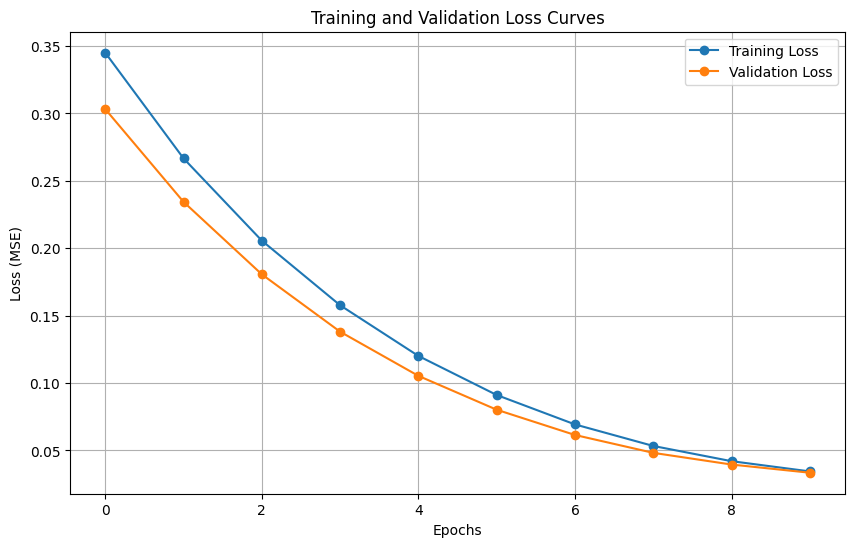

In [15]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2

In [21]:
import numpy as np
from sklearn.metrics import r2_score

# Example: Assume y_true and y_pred are (num_samples, 96) numpy arrays
def compute_r2(y_true, y_pred):
    """
    Computes global R² and per-timestep R² for multi-step forecasting.
    
    Args:
    y_true: np.array of shape (num_samples, 96) - actual values
    y_pred: np.array of shape (num_samples, 96) - predicted values
    
    Returns:
    - Global R² score
    - Per-timestep R² scores (averaged over all samples)
    """
    
    # Flatten y_test and y_pred for Global R²
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    global_r2 = r2_score(y_true_flat, y_pred_flat)

    # Compute R² per timestep
    timestep_r2_scores = [r2_score(y_test[:, t], y_pred[:, t]) for t in range(y_test.shape[1])]
    avg_r2_per_timestep = np.mean(timestep_r2_scores)
    
    return global_r2, timestep_r2_scores, avg_r2_per_timestep

# Example Data (Replace with actual test predictions and ground truth)
y_test = np.random.rand(720, 96)  # 100 samples, 96 time steps
y_pred = y_test + np.random.normal(0, 0.05, (720, 96))  # Adding some noise

# Compute R²
global_r2, timestep_r2_scores, avg_r2_per_timestep = compute_r2(y_test, y_pred)

print(f"Global R²: {global_r2:.4f}")
print(f"Average R² per timestep: {avg_r2_per_timestep:.4f}")

# Show the plot
plt.show()

Global R²: 0.9703
Average R² per timestep: 0.9702


In [22]:
y_test.shape  # (num_samples, sequence_length)
  # (num_samples, sequence_length)

(720, 96)

In [23]:
y_pred.shape

(720, 96)

In [24]:
from sklearn.metrics import r2_score

# Flatten both y_test and y_pred to make them 1D
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Compute Overall R² Score
r2_overall = r2_score(y_test_flat, y_pred_flat)
print(f"R² Score (Original Scale): {r2_overall:.4f}")

R² Score (Original Scale): 0.9703


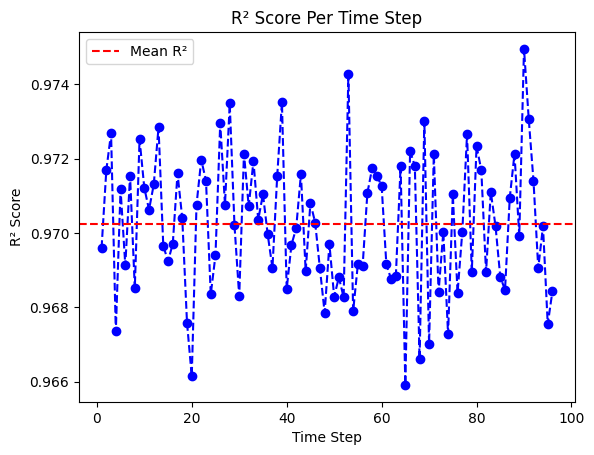

In [25]:
import matplotlib.pyplot as plt

r2_per_step = [r2_score(y_test[:, t], y_pred[:, t]) for t in range(y_test.shape[1])]

plt.plot(range(1, len(r2_per_step) + 1), r2_per_step, marker='o', linestyle='dashed', color='blue')
plt.axhline(y=np.mean(r2_per_step), color='red', linestyle='--', label="Mean R²")
plt.xlabel("Time Step")
plt.ylabel("R² Score")
plt.title("R² Score Per Time Step")
plt.legend()
plt.show()

First 10 Euclidean distances: [0.47992145 0.47030252 0.49286353 0.4646406  0.5198577  0.51364333
 0.47287906 0.45037973 0.51174881 0.48306546]
Euclidean distances saved to 'euclidean_distances.csv' successfully!


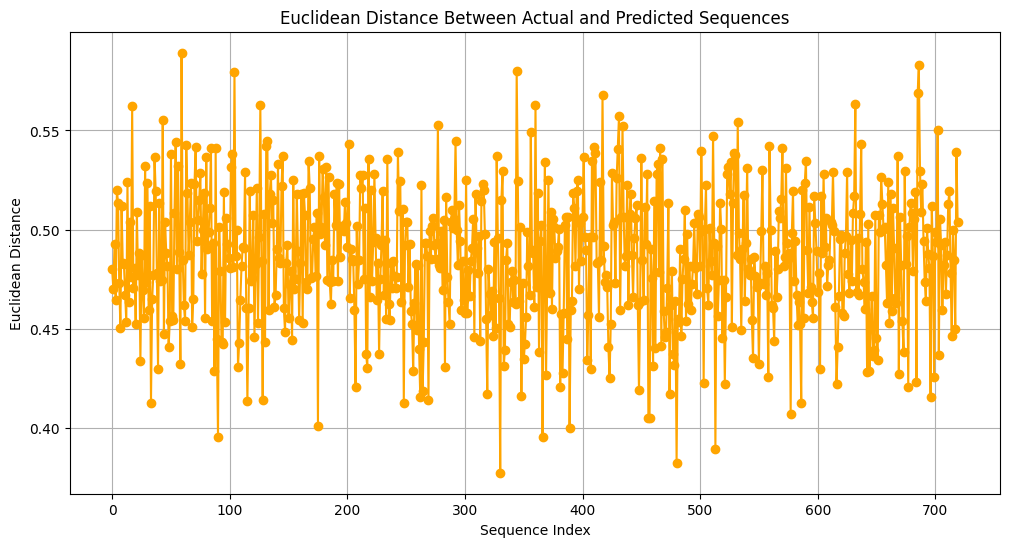

In [27]:
# Generate predictions
# y_pred = model.predict(X_test)  # Predict using test data

# Compute Euclidean distance for each sequence (row-wise)
euclidean_distances = np.linalg.norm(y_test - y_pred, axis=1)  # Compute distance for each sequence

# Print first few distances
print("First 10 Euclidean distances:", euclidean_distances[:10])

#Convert to a DataFrame
df_distances = pd.DataFrame({'Sequence_Index': np.arange(len(euclidean_distances)), 
                             'Euclidean_Distance': euclidean_distances})

#Save to CSV
df_distances.to_csv("euclidean_distances_0214_PM2.5.csv", index=False)

print("Euclidean distances saved to 'euclidean_distances.csv' successfully!")

#Plot Euclidean distances
plt.figure(figsize=(12, 6))
plt.plot(df_distances["Sequence_Index"], df_distances["Euclidean_Distance"], marker='o', linestyle='-', color='orange')
plt.xlabel("Sequence Index")
plt.ylabel("Euclidean Distance")
plt.title("Euclidean Distance Between Actual and Predicted Sequences")
plt.grid(True)
plt.show()